# Real-time face detection & ID identification model for fast check-in.

Shared Link to this notebook file: https://colab.research.google.com/drive/1LAW628pTdySumvdTRJkzIXzRuVhRyug4?usp=sharing

Dataset Link: https://drive.google.com/drive/folders/1p2Uzl727SvVA50C3hdkrX6BAk7yQEtWj?usp=sharing

Github Link: https://github.com/CZhao97/Facial-Indentity-Recognition-With-Masks

# Introduction

Human facial recognition is a classical task of computer vision and has already had many successful applications in for example, access control, attendance counting, facial security checks, etc.
Because of the outbreak of Covid-19, masks have become mandatory for most public areas. This poses challenges for the conventional facial recognition solutions because some important facial features, like the contour profile, nose and mouth are covered under masks. Therefore, we aim to develop a system that achieves facial recognition tasks under mask covering, and we achieved this with a CNN-based deep learning model.


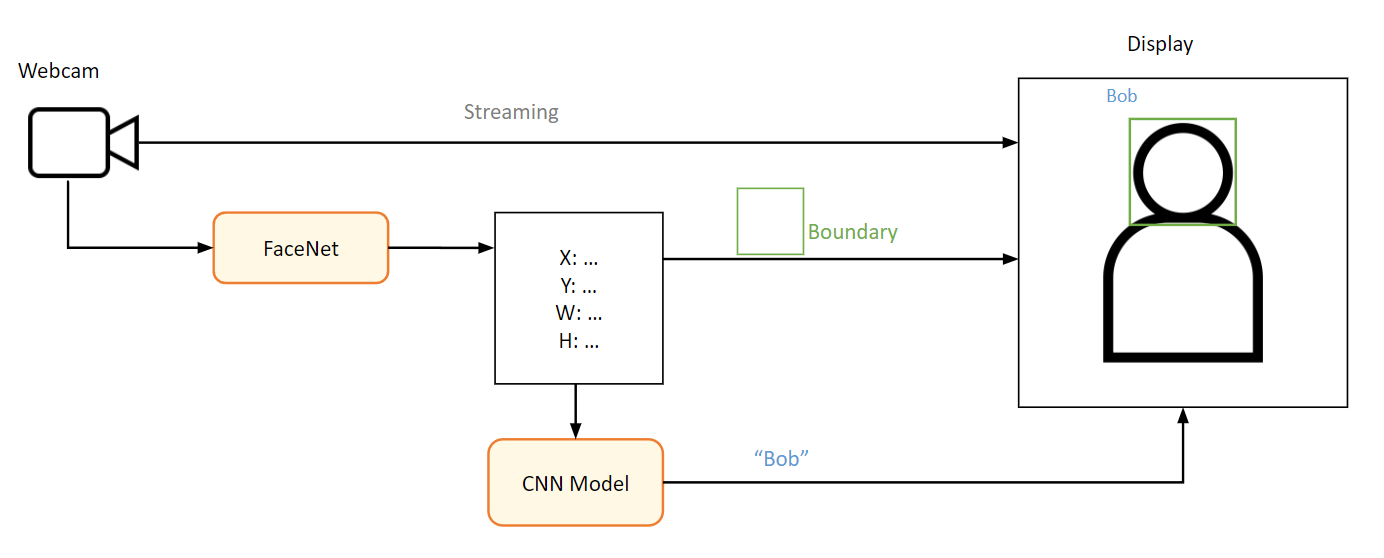

# Install necessary packages

In [ ]:
%%shell
pip install facenet-pytorch
pip install mmcv

     |████████████████████████████████| 1.9 MB 7.7 MB/s 
     |████████████████████████████████| 498 kB 8.4 MB/s 
     |████████████████████████████████| 190 kB 63.4 MB/s 
  Created wheel for mmcv: filename=mmcv-1.4.8-py2.py3-none-any.whl size=762284 sha256=a8e15ff6e6e9d051fca500ed5d12c90ec34af7c0300652c4b88a432e12934625
  Stored in directory: /root/.cache/pip/wheels/f5/a5/24/3bc956c9c1330a563691cfc6905df8e6b142ea0740b6f6fa87
Successfully built mmcv


# Import Dependencies

In [ ]:
from IPython.display import Javascript, Image
from IPython import display as dis
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import io
import html
import time
from IPython.core.display import Video
from facenet_pytorch import MTCNN
import torch
import mmcv, cv2
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
from os import listdir
from os.path import isfile, join
import re
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
from scipy.special import softmax

use_cuda = True

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#A faster helper model that can find faces from frames quicker that traditional mtcnn model
#It was used during project development, but not used in the final version due to computational power issue. 
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, stride, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames):
        """Detect faces in frames using strided MTCNN."""
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
                      
        boxes, probs = self.mtcnn.detect(frames[::self.stride])

        faces = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
        
        return faces

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
# currently using, for face detection
mtcnn = MTCNN(keep_all=True, min_face_size=224, device=device)
# A faster model, for future performance improvment 
mtcnn_fast = FastMTCNN(keep_all=True, min_face_size=224, device=device,stride=4)

Running on device: cuda:0


# Part A: Extracting training data from input videos.

We asked 12 people, including all the three group members, to record selfie videos from different angles. Then we use a trained network -- FaceNet, to extract frames from videos. The sampling rate are mannually adapted in each video to make sure each person has 90-120 pictures. We especially cropped the upper face area (with forhead and eyes) to solve our masked facial recognition task.

In [ ]:
uploaded_video = files.upload() # For uploading training video to colab, click cancel if have no file to upload
user_name = "HZL"               # User name of the above uploaded video

## Frames extraction: Extract each frame of user face, save to google drive

In [ ]:
video = mmcv.VideoReader('/content/HZL.mp4') #Select training video here
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video] #Extracting frames from video
frames_tracked = []
path = '/content/drive/MyDrive/ut/MIE1517_group_project/ImageDataset/HZL'               #Put in the output directory you want 
os.mkdir(path)
os.chdir(path)
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    img = np.array(frame)    
    faces, _ = mtcnn.detect(frame)                                           #Return coordinates of faces from mtcnn model

    if i%5==0:

      if faces is not None: 
        for (x,y,w,h) in faces:
          x_w_diff = int(w-x)
          y_h_diff = int(h-y)
          if x_w_diff > 223. and y_h_diff >223.:
            x_w_mid = int(x+(w-x)/2)
            y_h_mid = int(y+(h-y)/2)
            selected_x = x_w_mid - 155
            selected_w = x_w_mid + 155
            selected_y = y_h_mid - 260
            selected_h = y_h_mid + 50           
            selected_img = img[selected_y:selected_h, selected_x:selected_w, :] #Adjustment for cropping the correct face images.

            faces = Image.fromarray(selected_img).resize((224,224))             #Resizing the image to desired input size.
      
            gray_img = cv2.cvtColor(np.array(faces), cv2.COLOR_RGB2GRAY)        #Converting to Gray Scale images for training
            cv2.imwrite(user_name + str(i) + '.png', gray_img)
            #plt.imshow(gray_img, cmap = 'gray')                                #Displaying images only for developing, commented out in actual practice.
            #plt.show() 
    else:
      continue                                                     
          

print('\nDone')

Tracking frame: 278
Done


## ID identification MODEL and TRAINING method.

We will use `ImageFolder` to load the categorical data. The label create by `ImageFolder` are integers begining from 0. We first see the correspondence of integer label to name label. Each class includes roughly 200 images.

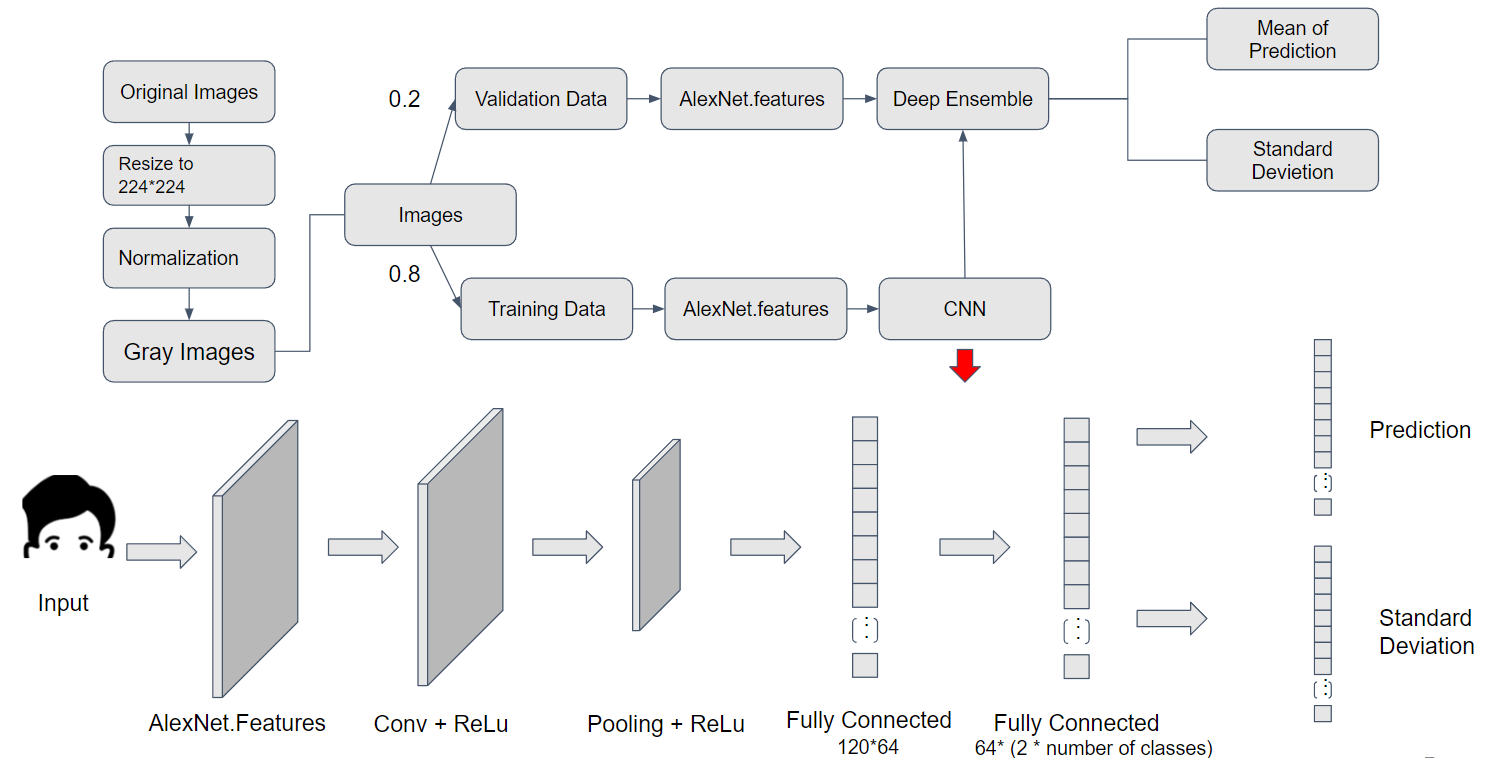

In [ ]:
### See Imagefolder label
dataset_path = '/content/drive/MyDrive/ut/MIE1517_group_project/FinalImgDataset'

transform = transforms.Compose([transforms.Resize((224, 224)),  
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])
data = datasets.ImageFolder(root=dataset_path, transform=transform)
print(data.class_to_idx)


{'Bob': 0, 'DYY': 1, 'HYL': 2, 'JCL': 3, 'LD': 4, 'ML': 5, 'Roy': 6, 'Ruihua': 7, 'Starlord': 8, 'WPL': 9, 'ZC': 10, 'Zijian': 11}


In [ ]:
#Helper method to create dataloaders
def split_data(dataset_path, batch_size=64):

    transform = transforms.Compose([transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])

    training_dataset = datasets.ImageFolder(root = dataset_path, transform=transform)

    indices = list(range(len(training_dataset)))

    np.random.shuffle(indices)

    split_train_val = int(0.8 * len(indices))

    train_indices, val_indices = indices[:split_train_val], indices[split_train_val:]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader, val_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, sampler=train_sampler), \
                  torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, sampler=val_sampler)
                    
    return train_loader, val_loader

##Brief visualization of the dataset

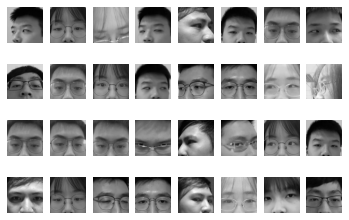

In [ ]:
train_loader, val_loader = split_data(dataset_path, batch_size = 32)

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(4, 8, k+1)
    plt.axis('off')
    plt.imshow(img)
    k += 1
    if k > 31:
        plt.show()
        break

In [ ]:
# AlexNet model, embedded in our model structure.
class AlexNetModel(nn.Module):

    def __init__(self, outputs):
        super(AlexNetModel, self).__init__()
        self.name = 'AlexNetModel'
        self.conv1 = nn.Conv2d(256, 30, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(120, 64)
        self.fc2 = nn.Linear(64, outputs*2)
        self.outputs = outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        mean, variance = torch.split(x, self.outputs, dim=1)
        variance = F.softplus(variance) + 1e-6
        return mean, variance


We will use a Gaussian mixture ensemble model as our deep learning model. While a CNN can only output deterministic results, an ensemble model could output a distribution. However, the posterior distribution is generally hard to estimate. Therefore, we model the posterior distribution as a multivariate Gaussian distribution, whose mean and variance can be estimated by sample mean and sample variance given by
$$\mu_{*}(\mathbf{x})=M^{-1} \sum_{m} \mu_{\theta_{m}}(\mathbf{x})$$

$$\sigma_{*}^{2}(\mathbf{x})=M^{-1} \sum_{m}\left(\sigma_{\theta_{m}}^{2}(\mathbf{x})+\mu_{\theta_{m}}^{2}(\mathbf{x})\right)-\mu_{*}^{2}(\mathbf{x})$$

To get the sample mean and sample variance, we set the output layer of the neural network to be a mean vector and a variance vector instead of the prediction (probability) vector.

We can set the loss function to be negative log-likelihood loss. The intuition is that we want to maximize the posterior probability of the observations.
$$-\log p_{\theta}\left(y_{n} \mid \mathbf{x}_{n}\right)=\frac{\log \sigma_{\theta}^{2}(\mathbf{x})}{2}+\frac{\left(y-\mu_{\theta}(\mathbf{x})\right)^{2}}{2 \sigma_{\theta}^{2}(\mathbf{x})}+\text { constant. }$$


In [ ]:
class GaussianMixtureAlex(nn.Module):
    """ Gaussian mixture AlexNet which outputs are mean and variance.

    Attributes:
        models (int): number of models
        inputs (int): number of inputs
        outputs (int): number of outputs
        hidden_layers (list of ints): hidden layer sizes

    """
    def __init__(self, num_models=5, outputs=1):
        super(GaussianMixtureAlex, self).__init__()
        self.name = 'GaussianMixtureAlex'
        self.num_models = num_models
        self.outputs = outputs
        for i in range(self.num_models):
            model = AlexNetModel(outputs=self.outputs)
            setattr(self, 'model_'+str(i), model)
            
    def forward(self, x):
        # connect layers
        means = []
        variances = []
        for i in range(self.num_models):
            model = getattr(self, 'model_' + str(i))
            mean, var = model(x)
            means.append(mean)
            variances.append(var)
        means = torch.stack(means)
        mean = means.mean(dim=0)
        variances = torch.stack(variances)
        variance = (variances + means.pow(2)).mean(dim=0) - mean.pow(2)
        return mean, variance 

In [ ]:
# Onehot encoder
def OneHotEncoder(ls, class_num = 12):
  unique_ls = list(set(ls))
  onehot_encoded = np.zeros((len(ls), class_num))
  for i in range(len(ls)):
    onehot_encoded[i][ls[i]] = 1
  return onehot_encoded
  
# function to save checkpoint
def save_checkpoint(model, batch_size, lr, epoch):
  model_path = "{}_{}_{}_{}".format(model.name, batch_size, lr, epoch)
  torch.save(model, model_path)
  print('Checkpoint of {} has been stored successfully!',format(model_path))


# negative loglikelyhood loss
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + ((y - mean).pow(2))/var).sum()

def get_accuracy(model, data_loader, grey_images_flag = False):
  correct = 0
  total = 0

  alexnet = torchvision.models.alexnet(pretrained=True)

  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage

    if grey_images_flag:

      grey_images = torchvision.transforms.Grayscale()(imgs)

      imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))

    imgs = alexnet.features(imgs)

    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    mean, _ = model(imgs)
    
    #select index with maximum prediction score
    pred = mean.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

def predict(model, data_loader, grey_images_flag = False):

  alexnet = torchvision.models.alexnet(pretrained=True)

  pred_ls, var_ls, std_ls = [], [], []

  for imgs, _ in data_loader:
    #############################################
    #To Enable GPU Usage

    if grey_images_flag:

      grey_images = torchvision.transforms.Grayscale()(imgs)

      imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))

    imgs = alexnet.features(imgs)

    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
    #############################################
    
    mean, var = model(imgs)
    
    #select index with maximum prediction score
    pred = torch.argmax(mean, dim=1)

    pred = pred.cpu().detach().numpy()

    var = var.cpu().detach().numpy()

    variance = [var[i][val] for i, val in enumerate(pred)]

    std = np.sqrt(variance)

    pred_ls = [*pred_ls, *pred]

    var_ls = [*var_ls, *variance]

    std_ls = [*std_ls, *std]

  return pred_ls, var_ls, std_ls

#Training function.
def train(model, dataset_path, opt, batch_size = 64, learning_rate=0.01, epochs=30, grey_images_flag = False):

  #############################################
  # input: grey_images_flag: boolean if gray image conversion is needed
  #############################################

  train_loader, val_loader = split_data(dataset_path, batch_size = batch_size)

  criterion = NLLloss

  optimizer = opt(model.parameters(), lr=learning_rate)
    
  iters, losses, train_acc, val_acc = [], [], [], []
  
  alexnet = torchvision.models.alexnet(pretrained=True)

  n = 0 # the number of iterations
  for epoch in range(epochs):
    for imgs, labels in iter(train_loader):

      if grey_images_flag:

        grey_images = torchvision.transforms.Grayscale()(imgs)

        imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))

      imgs = alexnet.features(imgs)

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()

        one_hot_labels = torch.from_numpy(OneHotEncoder(labels))

        labels = one_hot_labels.cuda()
      #############################################
  
      mean, var = model(imgs) 

      loss = NLLloss(labels, mean, var)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # save the current training information
    iters.append(n)
    losses.append(float(loss)/batch_size)
    train_acc.append(get_accuracy(model, train_loader, grey_images_flag = grey_images_flag))
    val_acc.append(get_accuracy(model, val_loader, grey_images_flag = grey_images_flag))
    print('Epoch{}, Train acc: {} | Val acc: {} '
              .format(epoch + 1, "%.5f" % train_acc[-1], "%.5f" % val_acc[-1]))
    n += 1
      
    if ((epoch+1) % 25 == 0):
      save_checkpoint(model, batch_size, learning_rate, epoch+1)

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch1, Train acc: 0.24747 | Val acc: 0.25000 
Epoch2, Train acc: 0.51150 | Val acc: 0.51471 
Epoch3, Train acc: 0.59522 | Val acc: 0.57721 
Epoch4, Train acc: 0.59154 | Val acc: 0.56250 
Epoch5, Train acc: 0.77737 | Val acc: 0.75368 
Epoch6, Train acc: 0.95492 | Val acc: 0.92279 
Epoch7, Train acc: 0.99724 | Val acc: 1.00000 
Epoch8, Train acc: 0.99724 | Val acc: 1.00000 
Epoch9, Train acc: 0.99724 | Val acc: 1.00000 
Epoch10, Train acc: 0.99816 | Val acc: 1.00000 
Epoch11, Train acc: 0.99816 | Val acc: 1.00000 
Epoch12, Train acc: 0.99908 | Val acc: 1.00000 
Epoch13, Train acc: 0.99724 | Val acc: 1.00000 
Epoch14, Train acc: 0.99908 | Val acc: 1.00000 
Epoch15, Train acc: 0.99908 | Val acc: 1.00000 
Epoch16, Train acc: 0.99908 | Val acc: 1.00000 
Epoch17, Train acc: 0.99908 | Val acc: 1.00000 
Epoch18, Train acc: 0.99908 | Val acc: 1.00000 
Epoch19, Train acc: 0.99908 | Val acc: 1.00000 
Epoch20, Train acc: 0.99908 | Val acc: 1.00000 
Epoch21, 

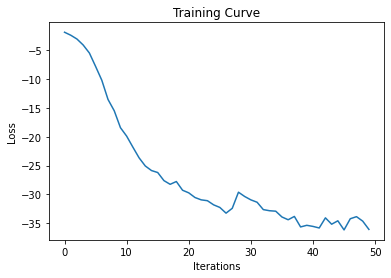

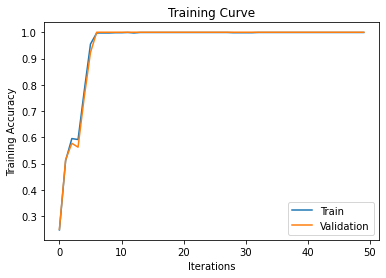

Final Training Accuracy: 0.9990800367985281
Final Validation Accuracy: 1.0


In [ ]:
class_num = 12

model = GaussianMixtureAlex(outputs = class_num)

data_path = 'E:/Codes/1517Project/Dataset/FacialDataset/ImageDataset/'


if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(model, data_path, opt = optim.Adam, batch_size = 128, learning_rate=0.0001, epochs=50, grey_images_flag = True)

In [ ]:
train_loader, val_loader = split_data(data_path, batch_size = 32)

In [ ]:
# pred, variance, std = predict(model, val_loader, grey_images_flag = True)

# Part B: Real time face detection & ID identification 

## Helper method for creating video streaming

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply): 
  image_bytes = b64decode(js_reply.split(',')[1])        # decode base64 image
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8) # convert bytes to numpy array
  img = cv2.imdecode(jpg_as_np, flags=1)                 # decode numpy array into OpenCV BGR image

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(ipt):
  # ipt: Numpy array (pixels) containing rectangle to overlay on video stream.
  # bytes: Base64 image byte string
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(ipt, 'RGBA')
  iobuf = io.BytesIO() 
  bbox_PIL.save(iobuf, format='png')                                                          # format bbox into png for return
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8'))) # format return string

  return bbox_bytes
  
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;   
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 720, 720);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = '<span style="color: red; font-weight: bold;">' + 'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 720; //video width; 1280
      captureCanvas.height = 720; //video height; 720
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Face detection model implementations

### Re-implementing face detection model, in case some unexpected changes were made in part A

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
# currently using, for face detection
mtcnn = MTCNN(keep_all=True, min_face_size=224, device=device)
# A faster model
mtcnn_fast = FastMTCNN(keep_all=True, min_face_size=224, device=device,stride=4)

Running on device: cuda:0


### Turning on webcam, start real-time ID recognition

In [ ]:
model = torch.load("/content/GaussianMixtureAlex_128_0.0001_50")

In [ ]:
from torch.functional import Tensor
video_stream()
label_html = 'Capturing Video...'
bbox = ''
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    
    img = js_to_image(js_reply["img"])                            #Calling helper method to convert JS response to OpenCV Image

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    frame = Image.fromarray(rgb_img)                              #Prepared input frame for mtcnn face detection model

    faces, _ = mtcnn.detect(frame)                                #Return coordinates of faces from mtcnn model

    bbox_array = np.zeros([720,720,4], dtype=np.uint8)            #Creating a transparent overlay for drawing bounding box

    if faces is not None: 
      for (x,y,w,h) in faces:
        x_w_diff = int(w-x)
        y_h_diff = int(h-y)
        if x_w_diff > 223. and y_h_diff >223.:                    #Size filtering, detected faces need to be clear enough (224 x 224)
          x_w_mid = int(x+(w-x)/2)                                #Finding the middle point along the x-axis
          y_h_mid = int(y+(h-y)/2)                                #Finding the middle point along the y-axis
          selected_x = x_w_mid - 140
          selected_w = x_w_mid + 140
          selected_y = y_h_mid - 260
          selected_h = y_h_mid + 20                               
 
          selected_img = img[selected_y:selected_h, selected_x:selected_w, :]  #Adjustment for cropping the correct face images.

          try:
            faces = Image.fromarray(selected_img).resize((224,224))
          except:
            label_html = "Move face to the center"
            continue
    
          gray_img = cv2.cvtColor(np.array(faces), cv2.COLOR_RGB2GRAY)
          
          input_for_face_recognition = torch.from_numpy(gray_img) 
          input_for_face_recognition = torch.stack([input_for_face_recognition], dim=0) #Prepared input in tensor format, Ready for our ID detection model
          

          # Facial identification process will be placed here

          transform = transforms.Compose([transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])

          faces = transform(faces)

          alexnet = torchvision.models.alexnet(pretrained=True)

          grey_images = torchvision.transforms.Grayscale()(faces)

          imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))
          
          imgs = alexnet.features(imgs)
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
          #############################################

          mean, var = model(imgs)

          confidence = nn.Softmax(dim=1)(mean)

          confidence = torch.max(confidence)

          #select index with maximum prediction score
          pred = torch.argmax(mean, dim=1)
          pred = pred.cpu().detach().numpy()
          name_dict = {0: 'Bob', 1: 'DYY', 2: 'HYL', 3: 'JCL', 4: 'LD', 5: 'ML', 6: 'Roy', 7: 'Ruihua Qiao', 8: 'Starlord', 9: 'WPL', 10: 'Chen Zhao', 11: 'Zijian Chen'}
          pred_name = name_dict[pred[0]]
          result = pred_name  # + " Confidence {}  Uncertainty {}".format(str(confidence.cpu().detach()) ,var[0][pred[0]])
          label_html = result

          box_height = (w,int(h-(20)))                                           #Adjusting the size of the bounding box to indicate detected faces.
          bbox_array = cv2.rectangle(bbox_array,(x,y), box_height, (0,255,0), 2) #Bounding box size and colour
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255  
      bbox_bytes = bbox_to_bytes(bbox_array)                                     # converting overlay of bbox into bytes  
      bbox =bbox_bytes                                                           # update bbox for the next frame  

<IPython.core.display.Javascript object>

During running, stream video will be displayed above, under the above cell. We use this real stream data as our test dataset.

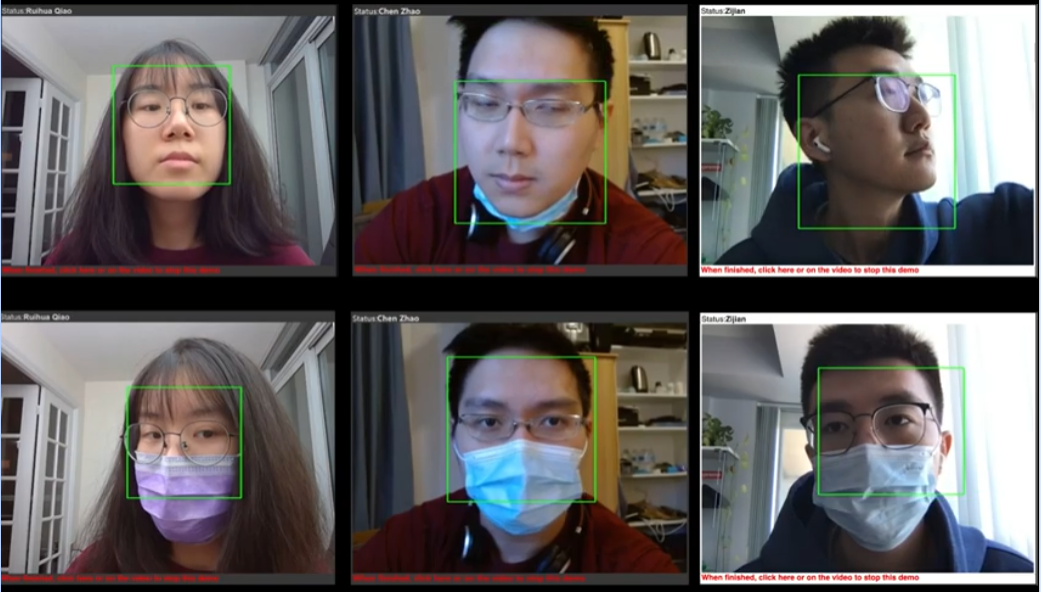

## Plot and Analysis

In [ ]:
# only one images are stored and retrieved from this sample folder
transform = transforms.Compose([transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])

sample_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/ut/MIE1517_group_project/sample", transform=transform)

sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=1)


In [ ]:
# get model prediction and variance for the sample image
for imgs, labels in sample_dataloader:

  alexnet = torchvision.models.alexnet(pretrained=True)

  imgs = alexnet.features(imgs)
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()

  mean, var = model(imgs)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
torch.argmax(mean, dim=1)

tensor([10], device='cuda:0')

In [ ]:
# showing the probabilities for each class
softmax(mean.cpu().detach())

tensor([[0.0784, 0.0796, 0.0831, 0.0783, 0.0798, 0.0774, 0.0781, 0.0782, 0.0771,
         0.0774, 0.1337, 0.0789]])

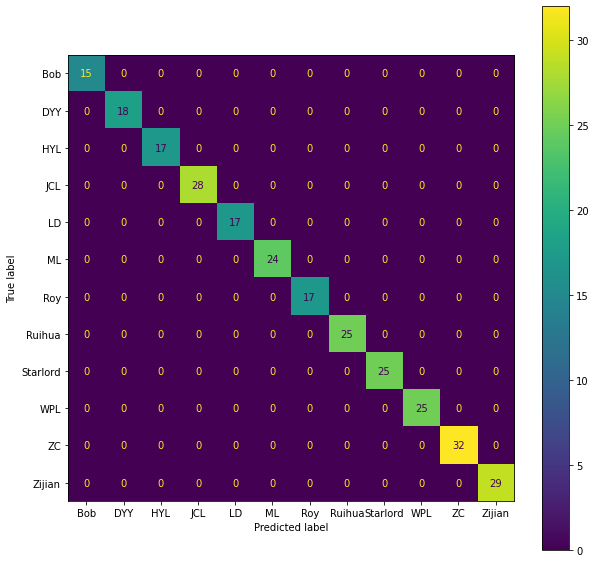

In [ ]:
# plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

true_label_ls = []

pred_ls = []

alexnet = torchvision.models.alexnet(pretrained=True)

for imgs, labels in iter(val_loader):

    grey_images = torchvision.transforms.Grayscale()(imgs)

    imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))

    imgs = alexnet.features(imgs)

    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
    #############################################
    
    mean, var = model(imgs)
    
    #select index with maximum prediction score

    pred = torch.argmax(mean.cpu().detach(), dim=1)

    true_label_ls = np.array([*true_label_ls, *labels])

    pred_ls = np.array([*pred_ls, *pred.tolist()])



inv_map = {v: k for k, v in data.class_to_idx.items()}

true_label_ls = [inv_map[i] for i in true_label_ls]

pred_ls = [inv_map[i] for i in pred_ls]

cm = confusion_matrix(true_label_ls, pred_ls, labels=list(data.class_to_idx.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(data.class_to_idx.keys()))

disp.plot()
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

## Similar project comparison

Comparing to other similar projects, our project uses CNN model to achieve the facial features extraction and recognization, while others are able to use 

1. Geometric Based / Template Based Approach (Face recognition algorithms classified as geometry based or template based algorithms.)

2. Piecemeal / Wholistic Approach (The relation between the elements or the connection of a function with the whole face not undergone into the amount, and some methods such as mostly focusing on eyes or combination of features to deduce the most relevant characteristics)

3. Appearance-Based / Model-Based Approach (The appearance-based method shows a face regarding several images which considered as a high dimensional vector. This technique is usually used to derive a feature space from the image division.)

# Discussion

We noticed that the training and validation is almost 100%, which is incredibly high. However, when testing on new videos using webcam, the model would sometimes make wrong recognitions. The reason for this seemingly inconsistensy is due to our acquisition of training dataset. Since we asked each person in our dataset to record one selfie video, the frames we extracted for each person are similar in terms of environment. Though we have standardized our input to eliminate lighting conditions, some local lights or shadows could be interpreted as identity features.

To solve this issue, we come up with two solutions, which we could try to impletement if given more time.
1. Record each selfie video in the same environment, e.g., ask the group of people in our dataset to come to the same place to record the video one by one. In this way, the environmental features are uniform; thus, the neural network will focus more on the facial features.
2. Ask each person to record selfie video in several environments. In this way, the neural network can also learn to disregard the environmental features and focus on facial features.

# References

[1] FaceNet. https://github.com/timesler/facenet-pytorch#quick-start

[2] https://www.kaggle.com/code/timesler/guide-to-mtcnn-in-facenet-pytorch/notebook

[3] Lakshminarayanan, Balaji, Alexander Pritzel, and Charles Blundell. "Simple and scalable predictive uncertainty estimation using deep ensembles." Advances in neural information processing systems 30 (2017).

[4] https://github.com/theAIGuysCode/colab-webcam


In [3]:
%%shell
jupyter nbconvert --to html Project_Face_detection.ipynb

[NbConvertApp] Converting notebook Project_Face_detection.ipynb to html
[NbConvertApp] Writing 1625604 bytes to Project_Face_detection.html


In [ ]:
# plot roc curve

# import numpy as np
# import matplotlib.pyplot as plt
# from itertools import cycle

# from sklearn import svm, datasets
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.metrics import roc_auc_score

# true_label_ls = []

# pred_score_ls = []

# alexnet = torchvision.models.alexnet(pretrained=True)

# for imgs, labels in iter(val_loader):

#     grey_images = torchvision.transforms.Grayscale()(imgs)

#     imgs = torch.tensor(np.tile(grey_images, [1,3,1,1]))

#     imgs = alexnet.features(imgs)

#     if use_cuda and torch.cuda.is_available():
#       imgs = imgs.cuda()
#     #############################################
    
#     mean, var = model(imgs)
    
#     #select index with maximum prediction score

#     # pred_score = torch.max(mean.cpu().detach(), dim=1)[0]

#     labels = OneHotEncoder(labels)

#     true_label_ls = np.array([*true_label_ls, *labels])

#     pred_score_ls = np.array([*pred_score_ls, *mean.cpu().detach().tolist()])

# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(12):
#     fpr[i], tpr[i], _ = roc_curve(true_label_ls[:, i], pred_score_ls[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(true_label_ls.ravel(), pred_score_ls.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plt.figure()
# lw = 2
# plt.plot(
#     fpr[2],
#     tpr[2],
#     color="darkorange",
#     lw=lw,
#     label="ROC curve (area = %0.2f)" % roc_auc[2],
# )
# plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver operating characteristic example")
# plt.legend(loc="lower right")
# plt.show()